In [318]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt

from numpy import genfromtxt

import sys
sys.path.append('../../models')
from models import firstordermodel, secondordermodel

sys.path.append('../')
from tools import stochasticSimulation, derive_regimes, solve_ivp_discrete, \
                    smooth_dap, sol_ivp_wrapper, smooth_regime, cost, sigmoid,\
                    simulate_MPC, mergeSwitchCont, plotSwitches


from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [322]:
# Define model
lambda_MELT = 0.00183*60
lambda_IDLE = 0.00085*60
mu_MELT = 66.92400 
mu_IDLE = 94.89100
sigma = 0.28130
R = 1.96580
pars = np.array([lambda_MELT, mu_MELT, lambda_IDLE, mu_IDLE, lambda_MELT, sigma, R])
m1 = firstordermodel(pars)

tf = 60 * 24
x0 = np.array(90)


# Extract switch solution from C++
switches = genfromtxt('../results/optimal_pars.csv', delimiter=',')
tau_MELT_all, tau_IDLE_all  = derive_regimes(switches,tf,1)
tau_MELT, tau_IDLE  = derive_regimes(switches,tf,0)
switches = np.concatenate((tau_MELT, tau_IDLE))

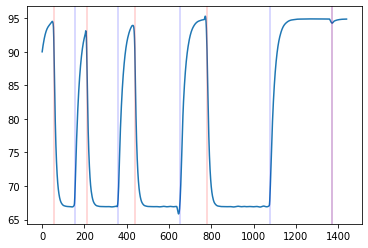

In [325]:
# Plot solution
t_eval = np.linspace(0,tf,1000)
sol = solve_ivp(m1.f, [0, tf], [x0], args=(switches,),t_eval=t_eval)
y_og = sol.y[0]
plt.plot(sol.t,y_og)
plotSwitches(switches,plt)

In [326]:
n_s = int(len(switches)/2)
switches
adjust = np.zeros(len(switches))
adjust[3] = 50
switches[:n_s], switches[n_s:]

(array([  54.7997,  210.092 ,  436.999 ,  780.205 , 1368.89  ]),
 array([ 154.472,  358.417,  652.315, 1077.91 , 1368.89 ]))

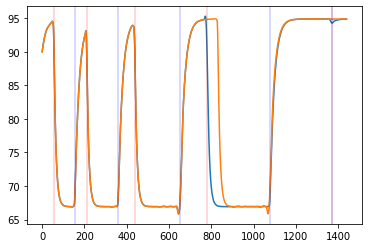

In [327]:
updated_switch = switches + adjust
sol = solve_ivp(m1.f, [0, tf], [x0], args=(updated_switch,),t_eval=t_eval)
y_adj = sol.y[0]
plt.plot(sol.t,y_og)
plt.plot(sol.t,y_adj)
plotSwitches(switches,plt)

In [363]:
# Expand f to also compute the cost
def f_with_cost(t,x,model,dap,switches,k,k_IDLE,k_MELT):
    
    # first nx-2 values is the state of the process
    # -2 value is the total power consumption
    # -1 is the total cost
    price = smooth_dap(t,dap)
    model_regime = smooth_regime(t,switches)

    nx = x.size
    x_no_cost = x[:-2]
    dxdt_no_cost = model.f(t,x_no_cost,switches)
    dxdt = np.zeros(len(dx)+2)

    # Normal process
    for i in range(nx-2):
        dxdt[i] = dxdt_no_cost[i]

    # Consumption
    dxdt[nx-2] = (k * model.h(x_no_cost) +  model_regime * k_MELT + (1-model_regime) * k_IDLE) * 1./60;
    # Cost
    dxdt[nx-1] = price * (k * model.h(x_no_cost) +  model_regime * k_MELT + (1-model_regime) * k_IDLE) * 1./60.;   
    return(dxdt)

In [364]:
f_with_cost(400,np.array([90.,0.,0.]),m1,dap,switches,k,k_IDLE,k_MELT)

array([2.49436743e-01, 1.86150006e+02, 4.77296296e-03])

In [365]:
tf

1440

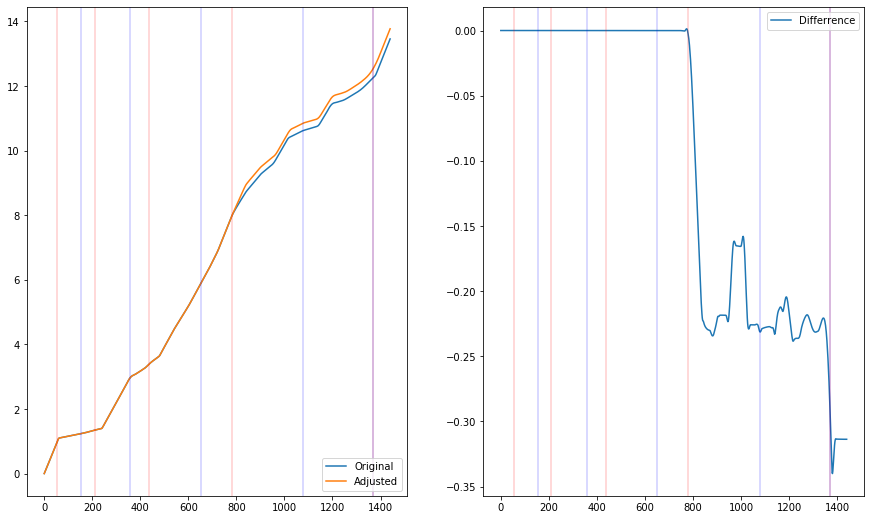

In [372]:
# Compute usage in every hour with and without adjustment
dap = 1/1000000 * (10 + 6.8 * np.array([12.5,0.01,0.125,0.12,12.4,12.3,2.3,4,12.6,11,12.5,10,12.6,11,7.5,5,11.8,2.4,0.3,7.6,0.3,2,4,12.5]))
k = 12400.
k_MELT = 250.
k_IDLE = 9.

sol_og = solve_ivp(f_with_cost, [0, tf], np.array([90.,0.,0.]), args=(m1,dap,switches,k,k_IDLE,k_MELT),t_eval=t_eval)
sol_adjust = solve_ivp(f_with_cost, [0, tf], np.array([90.,0.,0.]), args=(m1,dap,updated_switch,k,k_IDLE,k_MELT),t_eval=t_eval)

fig = plt.figure(figsize = (15,9))
ax1 = fig.add_subplot(121)

ax1.plot(sol_og.t,sol_og.y[-1],label = "Original")
ax1.plot(sol_og.t,sol_adjust.y[-1],label = "Adjusted")
plotSwitches(switches,ax1)
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(sol_og.t,sol_og.y[-1] - sol_adjust.y[-1],label = "Differrence")
plotSwitches(switches,ax2)
ax2.legend()


## Difference in usage

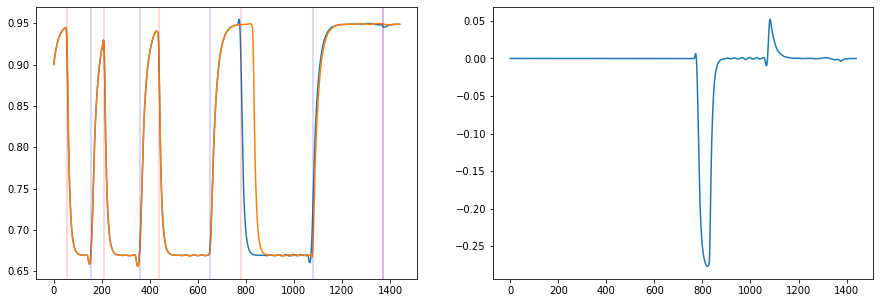

In [373]:
#t_hour = np.array([60 * hour for hour in range(24)])

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

us1 = m1.h(sol_og.y[:-2])[0]
us2 = m1.h(sol_adjust.y[:-2])[0]
ax1.plot(sol_og.t, us1)


ax1.plot(sol_og.t, us2)
plotSwitches(switches,ax1)
#switches[:n_s]

ax2.plot(sol_og.t,us1 - us2)

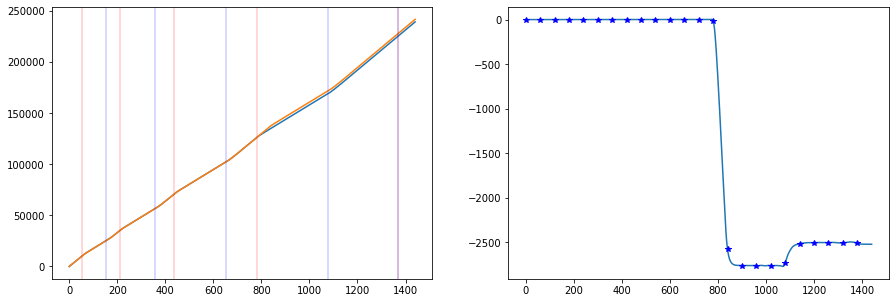

In [375]:
## Difference in intergrated usage
t_hour = np.array([60 * hour for hour in range(24)])

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

us1 = sol_og.y[-2]
us2 = sol_adjust.y[-2]
ax1.plot(sol_og.t, us1)


ax1.plot(sol_og.t, us2)
plotSwitches(switches,ax1)
switches[:n_s]

ax2.plot(sol_og.t,us1 - us2)

sol_og_hour = solve_ivp(f_with_cost, [0, tf], np.array([90.,0.,0.]), args=(m1,dap,switches,k,k_IDLE,k_MELT),t_eval=t_hour)
sol_adjust_hour = solve_ivp(f_with_cost, [0, tf], np.array([90.,0.,0.]), args=(m1,dap,updated_switch,k,k_IDLE,k_MELT),t_eval=t_hour)

ax2.plot(sol_og_hour.t, sol_og_hour.y[-2] - sol_adjust_hour.y[-2], 'b*' )


In [369]:
diff_par_hour = sol1.y[-1]- sol2.y[-1]
diff_par_hour

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -6.07275608e-08,
       -2.00698248e-04, -2.56389488e-02, -1.99381605e-01, -2.30620937e-01,
       -2.57449606e-01, -2.56801247e-01, -2.52092120e-01, -2.33206936e-01,
       -1.87286006e-01, -1.67465166e-01, -1.44413056e-01, -1.50235373e-01])

In [360]:
prices = pd.read_csv('../../data/Regulating_prices.csv', index_col=0, skiprows=1,header=1)  

In [202]:
prices = prices[{'DKUp','DKDown'}]
prices = prices.apply(lambda x: x.str.replace(',','.'))

In [205]:
up = prices['DKUp'].values.astype(np.float)[:24]
down = prices['DKDown'].values.astype(np.float)[:24]

In [206]:
down

array([ 4.5 ,  4.5 ,  4.5 ,  4.86,  4.3 ,  4.  ,  4.  ,  4.3 ,  5.32,
        8.  ,  8.  , 25.36, 17.62,  5.32,  4.05,  4.05,  4.  ,  4.3 ,
        6.5 , 28.23, 24.46,  8.8 ,  9.04,  9.43])

In [217]:
np.random.seed(1234)
which_market = np.random.choice([-1.,0.,1.], 24, p=[1/3, 1/3, 1/3]) # -1: Down, 0: Dap, 1: Up
which_market

array([-1.,  0.,  0.,  1.,  1., -1., -1.,  1.,  1.,  1.,  0.,  0.,  1.,
        1.,  0.,  0.,  0., -1.,  1.,  1.,  0.,  0., -1.,  0.])

In [381]:
up = (which_market + 1) * which_market/2
down = (which_market - 1) * which_market/2
up,down

(array([-0.,  0.,  0.,  1.,  1., -0., -0.,  1.,  1.,  1.,  0.,  0.,  1.,
         1.,  0.,  0.,  0., -0.,  1.,  1.,  0.,  0., -0.,  0.]),
 array([ 1., -0., -0.,  0.,  0.,  1.,  1.,  0.,  0.,  0., -0., -0.,  0.,
         0., -0., -0., -0.,  1.,  0.,  0., -0., -0.,  1., -0.]))

In [361]:
60 * 24 * k * 0.9 *

16070400.0

In [362]:
k * 0.9

11160.0